In [ ]:
!unzip '/content/drive/MyDrive/ESG 2024/교안/실습/datasets/Pneumonia.zip' -d '/content/drive/MyDrive/ESG 2024/교안/실습/datasets/Pneumonia'

## Simple CNN

In [2]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
# GPU 설정
import gc

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7680)]  # 7.5GB
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print("GPU Available: ", tf.config.list_physical_devices('GPU'))

class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data load, preprocessing

In [4]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
def load_and_preprocess_data(base_dir, img_size=(299, 299)):
    images = []
    labels = []
    categories = ['NORMAL', 'PNEUMONIA']

    for category in categories:
        class_num = categories.index(category)
        for subset in ['train', 'val', 'test']:
            subset_dir = os.path.join(base_dir, subset, category)
            for img_name in os.listdir(subset_dir):
                try:
                    img_path = os.path.join(subset_dir, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    # img = cv2.equalizeHist(img)
                    img = cv2.resize(img, img_size)
                    img = img / 255.0

                    images.append(img)
                    labels.append(class_num)
                except Exception as e:
                    print(f"Error processing image {img_name}: {e}")

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    return images, np.array(labels)

def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=val_size, stratify=y_val_test, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
base_dir = 'datasets/Pneumonia'
X, y = load_and_preprocess_data(base_dir)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

# # 레이블을 원-핫 인코딩으로 변환
# y_train = to_categorical(y_train, 2)
# y_val = to_categorical(y_val, 2)
# y_test = to_categorical(y_test, 2)

print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (4684, 299, 299, 1), 레이블 형태: (4684,)
검증 데이터 형태: (586, 299, 299, 1), 레이블 형태: (586,)
테스트 데이터 형태: (586, 299, 299, 1), 레이블 형태: (586,)


### Modeling

In [7]:
def create_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
input_shape = (299, 299, 1)

model = create_simple_cnn(input_shape)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 322624)            0

### Model training

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

model = tf.keras.models.load_model('best_model.h5')

Epoch 1/100
147/147 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8888
Epoch 1: val_accuracy improved from -inf to 0.94198, saving model to best_model.h5
147/147 [==============================] - 17s 101ms/step - loss: 0.2697 - accuracy: 0.8888 - val_loss: 0.1671 - val_accuracy: 0.9420
Epoch 2/100
146/147 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9478
Epoch 2: val_accuracy did not improve from 0.94198
147/147 [==============================] - 13s 87ms/step - loss: 0.1309 - accuracy: 0.9479 - val_loss: 0.1464 - val_accuracy: 0.9403
Epoch 3/100
146/147 [============================>.] - ETA: 0s - loss: 0.0942 - accuracy: 0.9643
Epoch 3: val_accuracy improved from 0.94198 to 0.95392, saving model to best_model.h5
147/147 [==============================] - 13s 88ms/step - loss: 0.0940 - accuracy: 0.9643 - val_loss: 0.1397 - val_accuracy: 0.9539
Epoch 4/100
146/147 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy:

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

19/19 [==============================] - 1s 28ms/step - loss: 0.2967 - accuracy: 0.9420
Test accuracy: 0.9420


In [ ]:
# # loop로 생성
# def create_simple_cnn(input_shape, num_conv_layers=3, filters=(32, 64, 64)):
#     model = Sequential()
#     model.add(Conv2D(filters[0], (3, 3), activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D((2, 2)))

#     for i in range(1, num_conv_layers):
#         model.add(Conv2D(filters[i], (3, 3), activation='relu'))
#         model.add(MaxPooling2D((2, 2)))

#     model.add(Flatten())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(2, activation='softmax'))

#     return model

# # 모델 생성
# input_shape = (299, 299, 1)
# model = create_simple_cnn(input_shape, num_conv_layers=3, filters=(32, 64, 128))

19/19 [==============================] - 1s 26ms/step


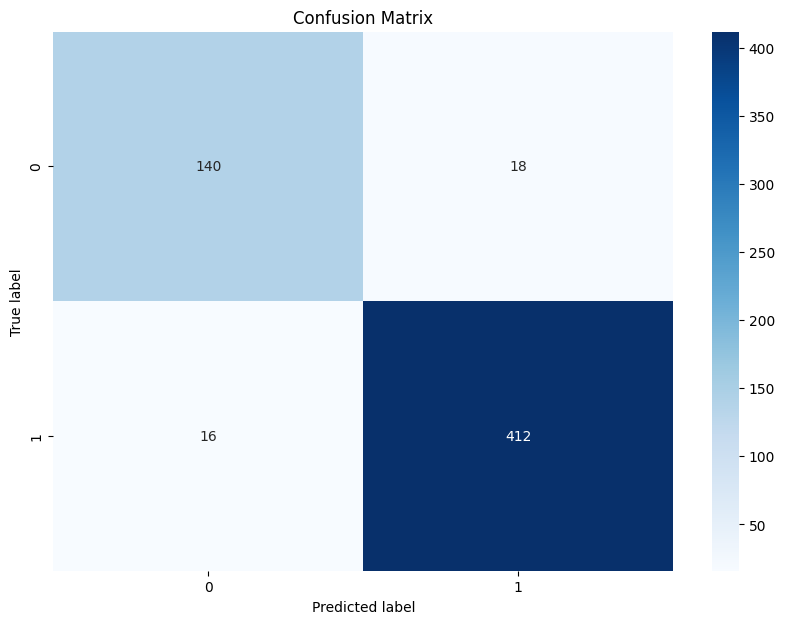

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       158
           1       0.96      0.96      0.96       428

    accuracy                           0.94       586
   macro avg       0.93      0.92      0.93       586
weighted avg       0.94      0.94      0.94       586



In [11]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_classes))

### Visualization

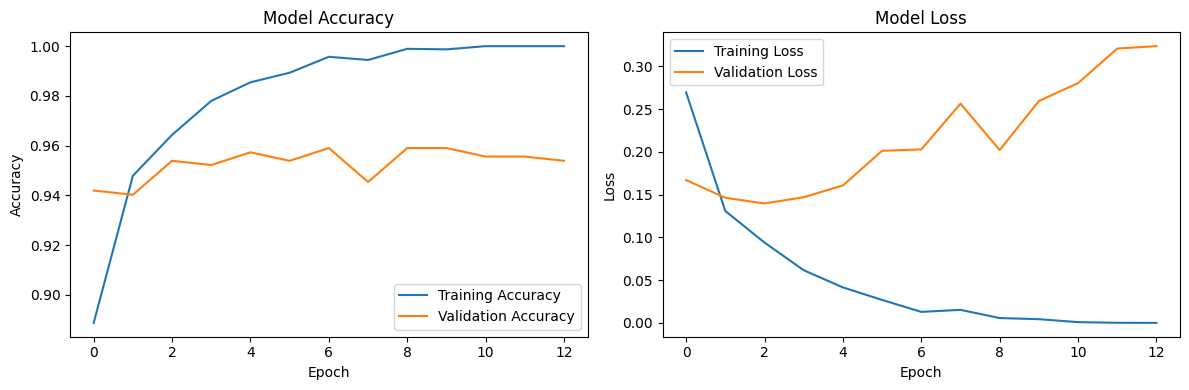

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## InceptionV3

In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [15]:
def create_inceptionv3_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

### Inception용 data 처리
    - channel: 1 -> 3

In [17]:
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# InceptionV3 전처리 적용: 사전 설정값
X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train_rgb)
X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val_rgb)
X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test_rgb)

# 모델 생성 및 컴파일
model = create_inceptionv3_model((299, 299, 3))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_inceptionv3_model.h5', save_best_only=True)
]

In [18]:
history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
147/147 [==============================] - 23s 128ms/step - loss: 0.4405 - accuracy: 0.7805 - val_loss: 0.4029 - val_accuracy: 0.8123
Epoch 2/50
147/147 [==============================] - 17s 116ms/step - loss: 0.3793 - accuracy: 0.8303 - val_loss: 0.3785 - val_accuracy: 0.8515
Epoch 3/50
147/147 [==============================] - 17s 117ms/step - loss: 0.3543 - accuracy: 0.8454 - val_loss: 0.3560 - val_accuracy: 0.8635
Epoch 4/50
147/147 [==============================] - 17s 118ms/step - loss: 0.3297 - accuracy: 0.8644 - val_loss: 0.3316 - val_accuracy: 0.8805
Epoch 5/50
147/147 [==============================] - 17s 118ms/step - loss: 0.3183 - accuracy: 0.8704 - val_loss: 0.3128 - val_accuracy: 0.8754
Epoch 6/50
147/147 [==============================] - 17s 115ms/step - loss: 0.2986 - accuracy: 0.8841 - val_loss: 0.2934 - val_accuracy: 0.8925
Epoch 7/50
147/147 [==============================] - 17s 117ms/step - loss: 0.2856 - accuracy: 0.8886 - val_loss: 0.2849 - val_ac

In [19]:
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f'Test accuracy: {test_acc:.4f}')

19/19 [==============================] - 2s 77ms/step - loss: 0.1851 - accuracy: 0.9403
Test accuracy: 0.9403


19/19 [==============================] - 4s 96ms/step


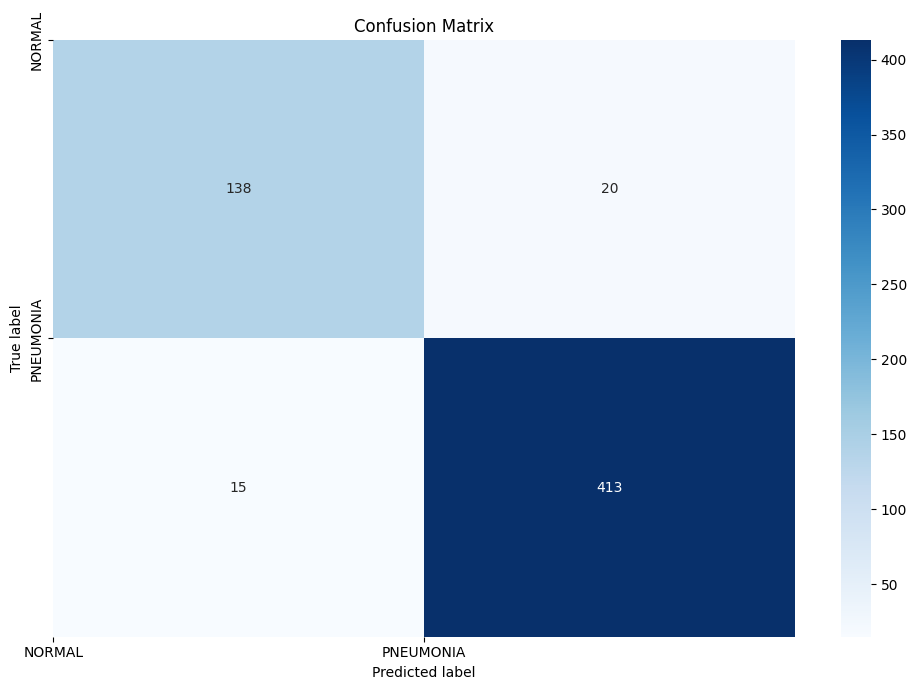

              precision    recall  f1-score   support

      NORMAL       0.90      0.87      0.89       158
   PNEUMONIA       0.95      0.96      0.96       428

    accuracy                           0.94       586
   macro avg       0.93      0.92      0.92       586
weighted avg       0.94      0.94      0.94       586



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_preprocessed)
y_pred_classes = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = ['NORMAL', 'PNEUMONIA']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred_classes, target_names=class_names))

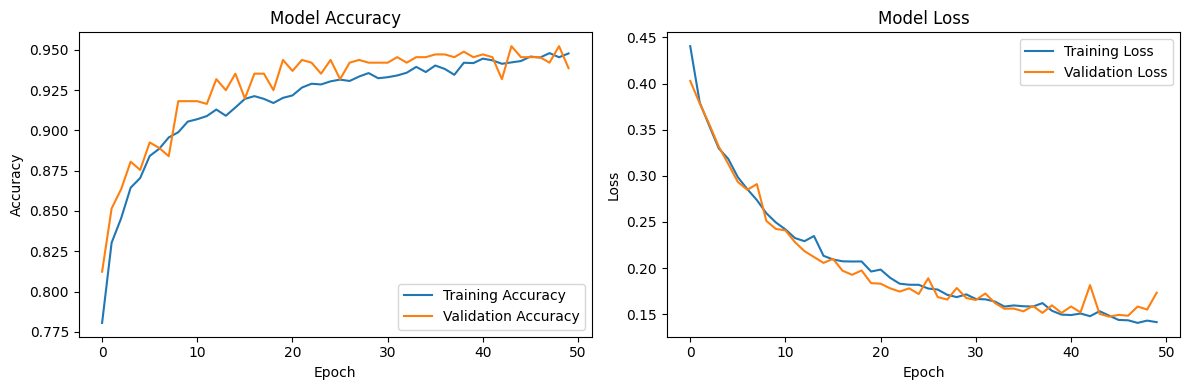

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

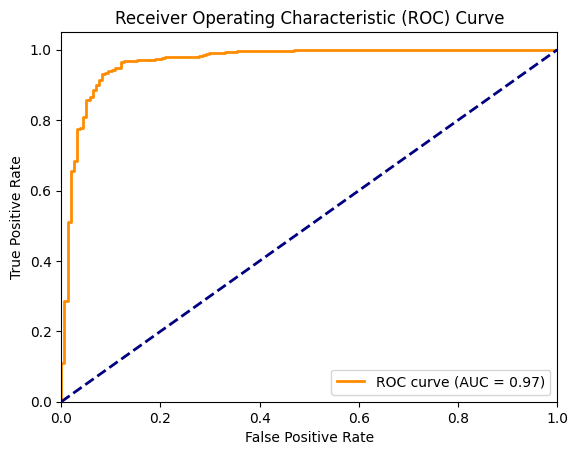

In [22]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()